# Analysis of Cardiotocography Features and Their Impact on Foetal Health

## Context

- Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
- The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

- Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

- In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. 
- The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

## Data
- This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological


- An obstetrician: is a physician that specializes in delivering babies and caring for people during pregnancy and after they give birth. They treat medical conditions unique to pregnancy and perform surgeries related to labor and delivery.

## Import Libraries

In [10]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import os


## Import Data

In [11]:
foetal_health_df=pd.read_csv(r'your file path')

## Data Understanding

In [12]:
foetal_health_df.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1


### Data Understanding/ Variable Interpretation


1. **Baseline Value (FHR Baseline)**:
   - **What It Represents**: The baseline fetal heart rate (FHR) measured in beats per minute (bpm).
   - **Why It Matters**: It provides a reference point for assessing deviations.
   - **Significance**: Abnormalities may indicate fetal distress.

2. **Accelerations**:
   - **What They Are**: The number of temporary increases in FHR.
   - **Why They Matter**: Accelerations are positive signs, showing fetal responsiveness.
   - **Interpretation**: More accelerations are reassuring.

3. **Fetal Movement**:
   - **What It Measures**: The number of fetal movements per second.
   - **Why It Matters**: Active movement indicates fetal well-being.
   - **Significance**: Reduced movement might signal a problem.

4. **Uterine Contractions (UC)**:
   - **What They Represent**: The number of contractions in the mother's uterus per second.
   - **Why They Matter**: Contractions play a role in labor progress.
   - **Normal Pattern**: Contractions become more frequent and intense during labor.
   - **Significance**: Abnormal contractions affect fetal oxygen supply.

5. **Decelerations**:
   - **What They Reflect**: Temporary decreases in FHR.
   - **Why They Matter**: Decelerations can indicate fetal stress.
   - **Interpretation**: Early decelerations (associated with contractions) are usually benign. Late or variable decelerations need attention.

6. **Variability**:
   - **What It Measures**: Fluctuations in FHR.
   - **Why It Matters**: Variability reflects the adaptability of the fetal nervous system.
   - **Interpretation**: Moderate variability is normal; reduced variability may signal distress.


7. **Histogram Tendency**:
    - **Definition**: Histogram tendency refers to the **shape** of the distribution displayed in a histogram.
    - **Interpretation**:
        - **Symmetric Distribution**: If the histogram is roughly symmetric (like a bell curve), it indicates that the data tends to cluster around a central value. This central value represents the **mean** or **average**.
        - **Skewed Distribution**:
            - **Positively Skewed (Right-Skewed)**: In a positively skewed distribution, the tail of the histogram extends toward higher values. This suggests that there are relatively fewer high values, and most data points are concentrated on the lower end.
            - **Negatively Skewed (Left-Skewed)**: In a negatively skewed distribution, the tail extends toward lower values. This implies that there are relatively fewer low values, and most data points cluster toward the higher end.
    - **Why It Matters**:
        - Understanding the histogram tendency helps us identify patterns in the data, such as whether it's centered around a specific value or skewed in one direction.

8. **Histogram Parameters**:
   - **Width**: Width of the FHR histogram.
   - **Minimum and Maximum**: Low and high frequencies in the histogram.
   - **Number of Peaks and Zeroes**: Features related to the shape of the histogram.

9. **Fetal Health Tag**:
   - **Categories**: Tagged as **1 (Normal)**, **2 (Suspect)**, or **3 (Pathological)** based on overall assessment.


## Data Processing

### Check Missingness

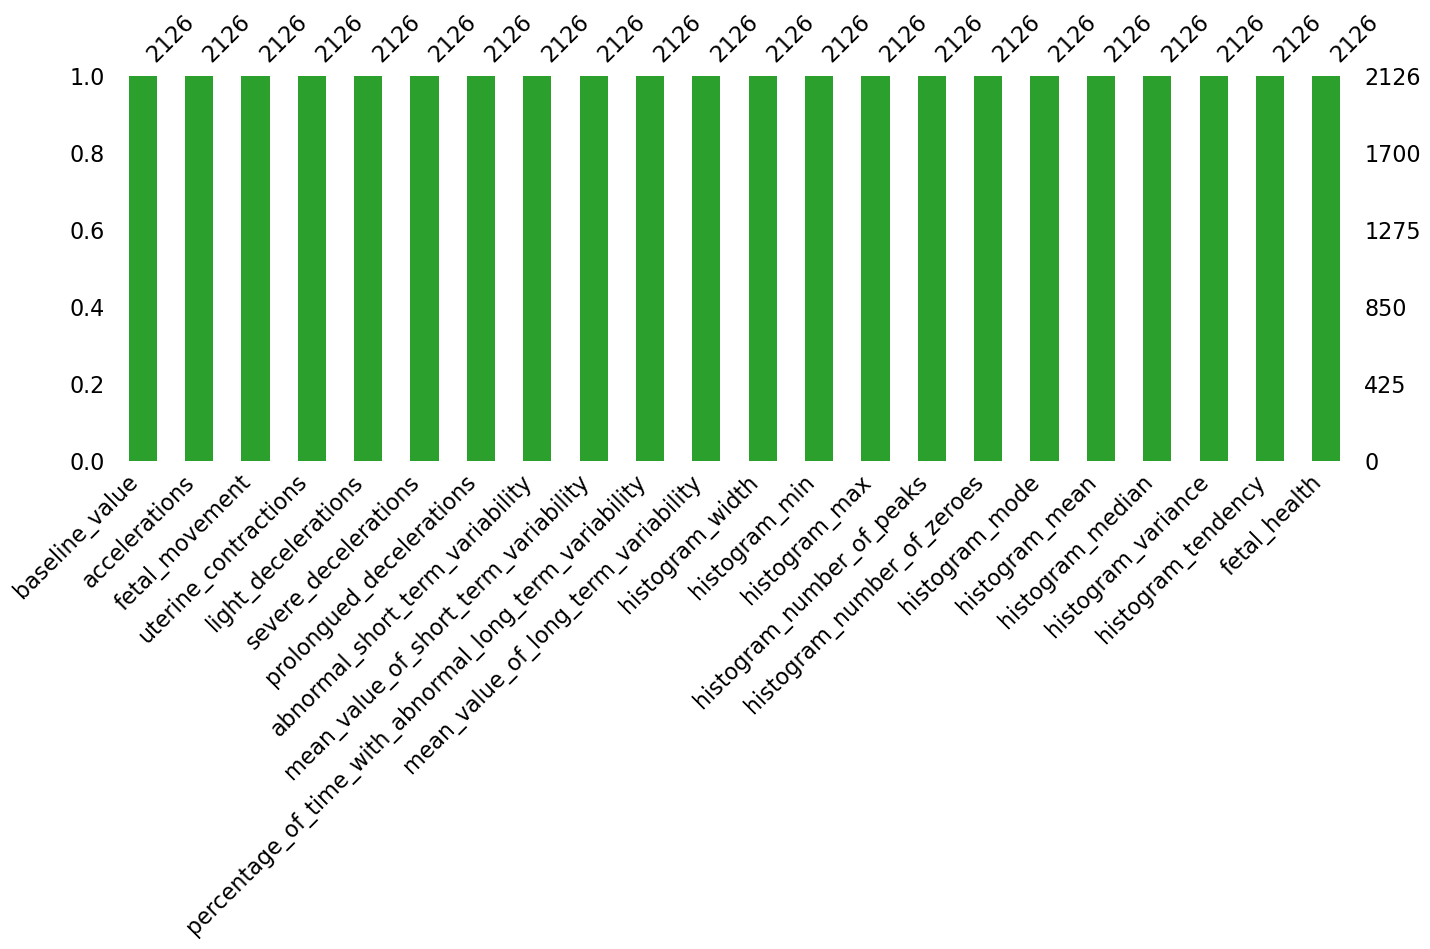

In [4]:
# Visualizing the missing values in the dataset
missing_values = msno.bar(foetal_health_df, figsize=(16, 5), color="#2ca02c")
plt.show()

- No missing values in the dataset

### Data Type Check

In [5]:
foetal_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline_value                                          2126 non-null   int64  
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   int64  
 8   mean_value_of_short_term_variability  

- 'fetal_health' and 'histogram_tendency' have been assigned integer type. Should be changed into object type

In [6]:
foetal_health_df['fetal_health'] = foetal_health_df['fetal_health'].astype(object)
foetal_health_df['histogram_tendency'] = foetal_health_df['histogram_tendency'].astype(object)

In [7]:
# Assign Normal, Suspect and Pathological to 1, 2, and 3 respectively for the 'fetal_health' variable
foetal_health_df['fetal_health'] = foetal_health_df['fetal_health'].replace({1.0: 'Normal', 2.0: 'Suspect', 3.0: 'Pathological'})

### Duplicates Check

In [8]:
foetal_health_df.duplicated().sum()

13

- There are a total of 13 duplicated records.

### Duplicates Confirmation

In [9]:
foetal_health_df[foetal_health_df.duplicated(keep=False)].sort_values(by='baseline_value', ascending=True)

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
1115,122,0.000,0.000,0.000,0.0,0.0,0.0,19,1.9,0,...,103,142,1,0,120,120,122,3,0,Normal
1114,122,0.000,0.000,0.000,0.0,0.0,0.0,19,1.9,0,...,103,142,1,0,120,120,122,3,0,Normal
1113,122,0.000,0.000,0.000,0.0,0.0,0.0,19,1.9,0,...,103,142,1,0,120,120,122,3,0,Normal
1112,122,0.000,0.000,0.000,0.0,0.0,0.0,19,1.9,0,...,103,142,1,0,120,120,122,3,0,Normal
787,123,0.003,0.003,0.000,0.0,0.0,0.0,52,0.8,2,...,50,140,7,0,129,128,130,4,1,Normal
229,123,0.003,0.003,0.000,0.0,0.0,0.0,52,0.8,2,...,50,140,7,0,129,128,130,4,1,Normal
233,123,0.000,0.000,0.000,0.0,0.0,0.0,49,0.8,7,...,63,137,2,0,129,127,129,2,1,Normal
234,123,0.000,0.000,0.000,0.0,0.0,0.0,49,0.8,7,...,63,137,2,0,129,127,129,2,1,Normal
790,123,0.003,0.004,0.000,0.0,0.0,0.0,50,0.9,4,...,58,140,7,0,129,128,130,5,1,Normal
791,123,0.003,0.004,0.000,0.0,0.0,0.0,50,0.9,4,...,58,140,7,0,129,128,130,5,1,Normal


### Drop Duplicated Records

In [10]:
foetal_health_df = foetal_health_df.drop_duplicates()

### Confirm Drop of Duplicated Records

In [11]:
foetal_health_df.duplicated().sum()

0

### Outlier Detection

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300')])

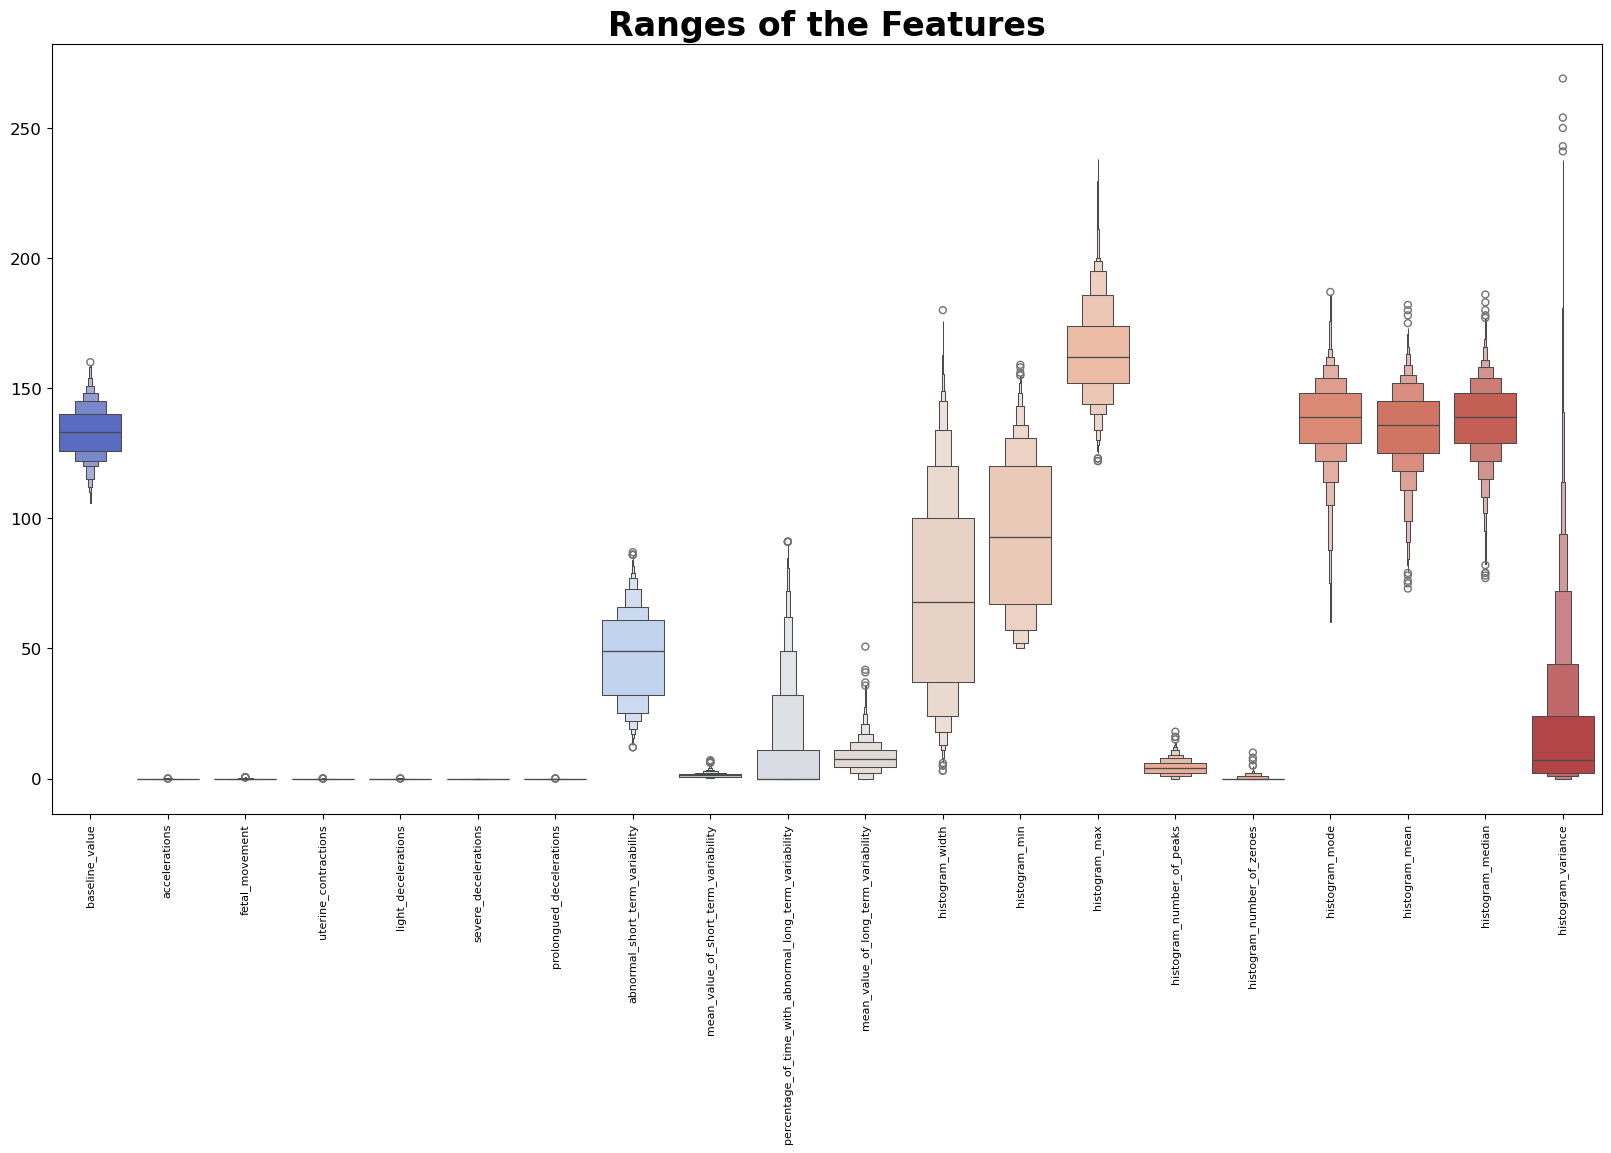

In [12]:
# Select numeric variables (float64)
numeric_variables = foetal_health_df.select_dtypes(include=['float64','int64'])
# Ranges of the features
plt.figure(figsize=(20, 10))
sns.boxenplot(data=numeric_variables, palette='coolwarm')

plt.title('Ranges of the Features',
          fontsize=24,
          fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=12)

- There are  outliers on the dataset as indicated by observations whose values are outside the boxplot whiskers. 
- However, it is not quite a good idea to remove them yet even though we may end up with better statistics.
- The removal of outliers follows a judicious process and they can only be removed if in deed their occurrence is due to error.
- In this case, the results are the outcome of a CTG report so it is unlikely that this was a data entry error.
- The outliers will not be removed since their occurrence can not be confidently ascertained to be erroneous.

### Features Scaling

- The features have significantly different ranges as shown by the boxplots necessitating feature scaling to improves model convergence i.e., allowing models to efficiently find optimal parameters.

## Exploratory Data Analysis (EDA)

### Fetal Health Variable (Label)

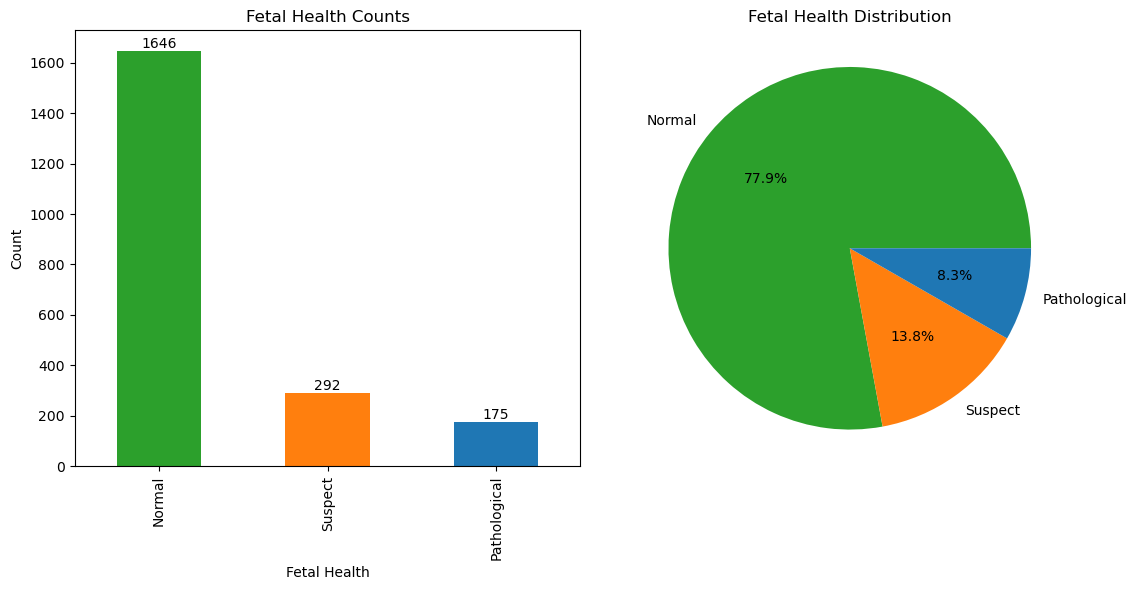

In [13]:
# Define colors for each category
colors = ['#2ca02c', '#ff7f0e', '#1f77b4']  # Green, Orange, Blue

# Set up the figure
plt.figure(figsize=(12, 6))

# Calculate counts for each category
counts = foetal_health_df['fetal_health'].value_counts()

# Plot the bar chart with counts
plt.subplot(1, 2, 1)
counts.plot(kind='bar', color=colors)
plt.title('Fetal Health Counts')
plt.xlabel('Fetal Health')
plt.ylabel('Count')

# Add numbers on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Plot the pie chart with percentages
plt.subplot(1, 2, 2)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Fetal Health Distribution')
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()

- The Normal category is distinctively the majority class while both the Suspect and Pathological are distinctively the minority classes.

### Distribution of Histogram Tendency by Fetal Health

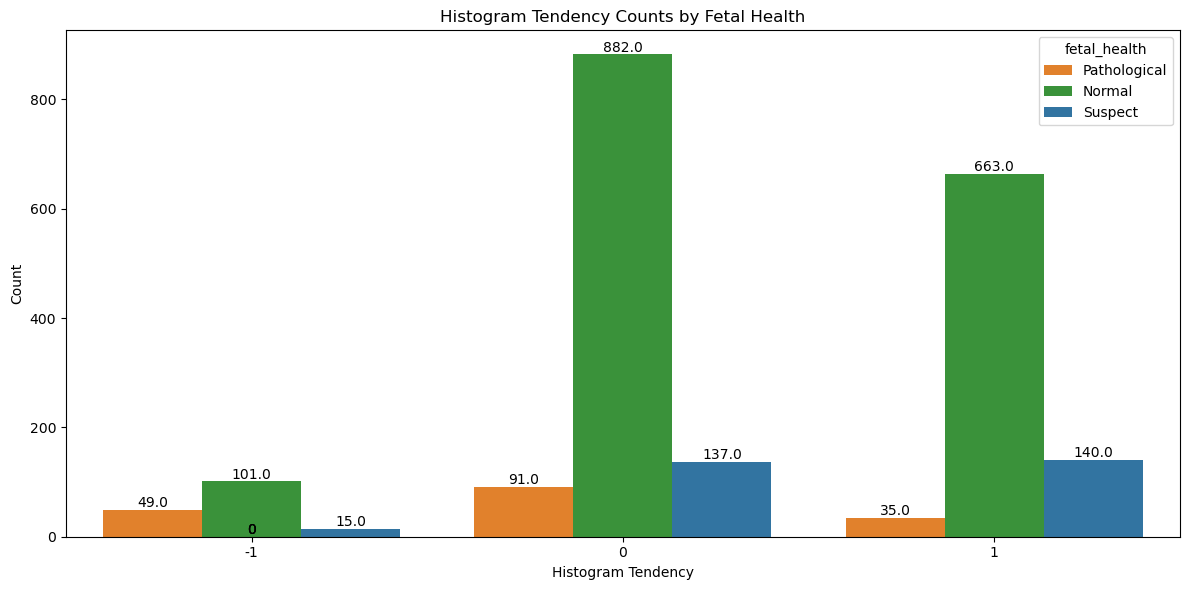

In [14]:
# Define colors for each category
colors = ['#ff7f0e', '#2ca02c', '#1f77b4']  # Green, Orange, Blue

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the countplot with bars broken by 'histogram_tendency'
ax = sns.countplot(data=foetal_health_df, x='histogram_tendency', hue='fetal_health', palette=colors)
plt.title('Histogram Tendency Counts by Fetal Health')
plt.xlabel('Histogram Tendency')
plt.ylabel('Count')

# Add numbers on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


- The majority fetal health category (Normal) dominates the categories of the histogram tendency.
- The Suspect category is the second largest for all categories of the histogram tendency, save for (-1) in which it's the least with a count of 15.

### Variable Characteristics

In [15]:
# Select numeric variables (float64)
numeric_variables = foetal_health_df.select_dtypes(include=['float64','int64'])

# Select categorical variables (objects)
categorical_variables = foetal_health_df.select_dtypes(include='object')

# Display information about numeric variables
print("Numeric Variables:")
print(numeric_variables.describe())

Numeric Variables:
       baseline_value  accelerations  fetal_movement  uterine_contractions  \
count     2113.000000    2113.000000     2113.000000           2113.000000   
mean       133.304780       0.003188        0.009517              0.004387   
std          9.837451       0.003871        0.046804              0.002941   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.005000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2113.000000           2113.000000               2113.000000   
mean              0.001901              0.000003                  0.000159   
std               0.002966              0.00

In [16]:
# Display information about categorical variables
print("\nCategorical Variables:")
print(categorical_variables.describe())


Categorical Variables:
        histogram_tendency fetal_health
count                 2113         2113
unique                   3            3
top                      0       Normal
freq                  1110         1646


### Distribution of Numeric Variables

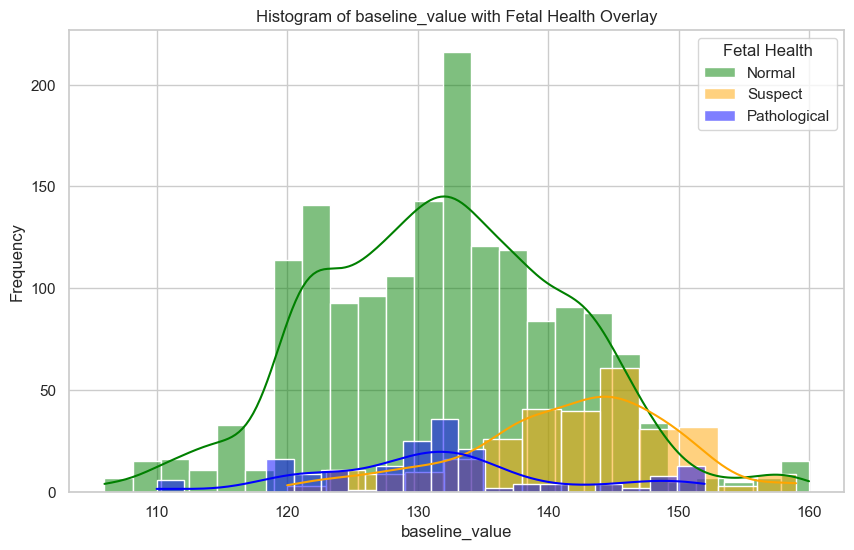

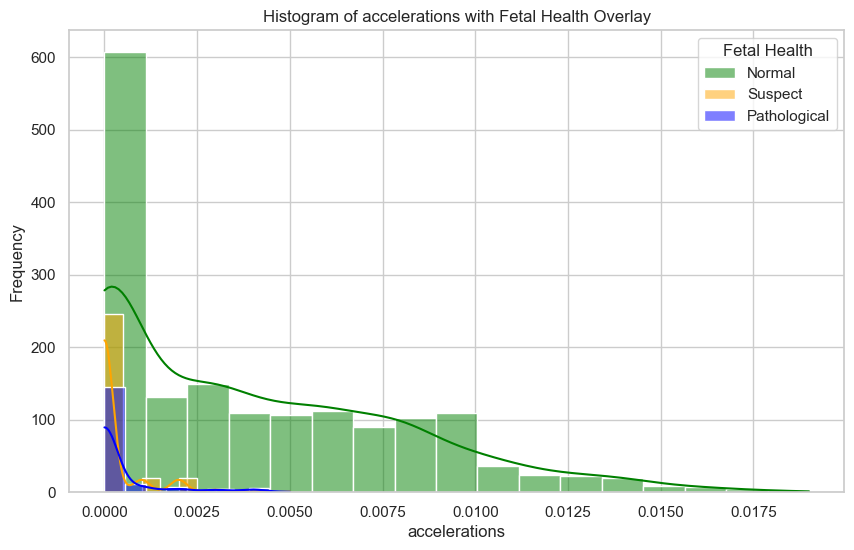

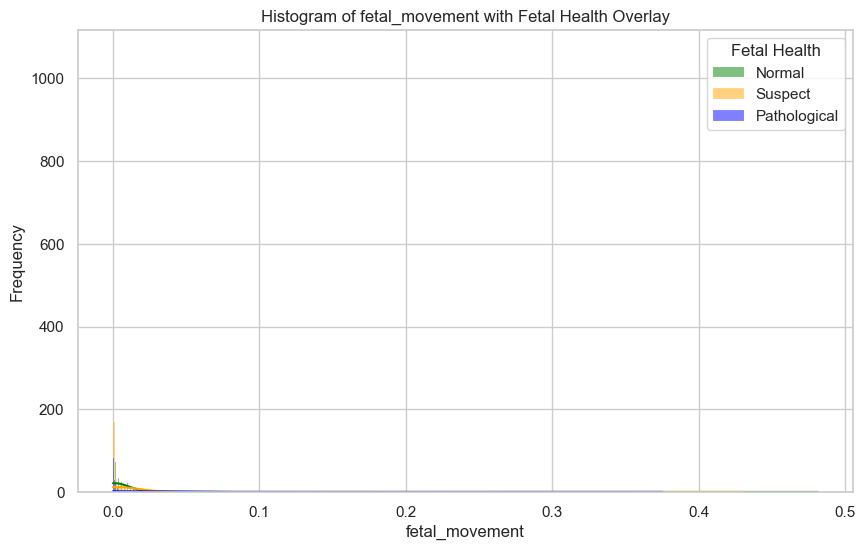

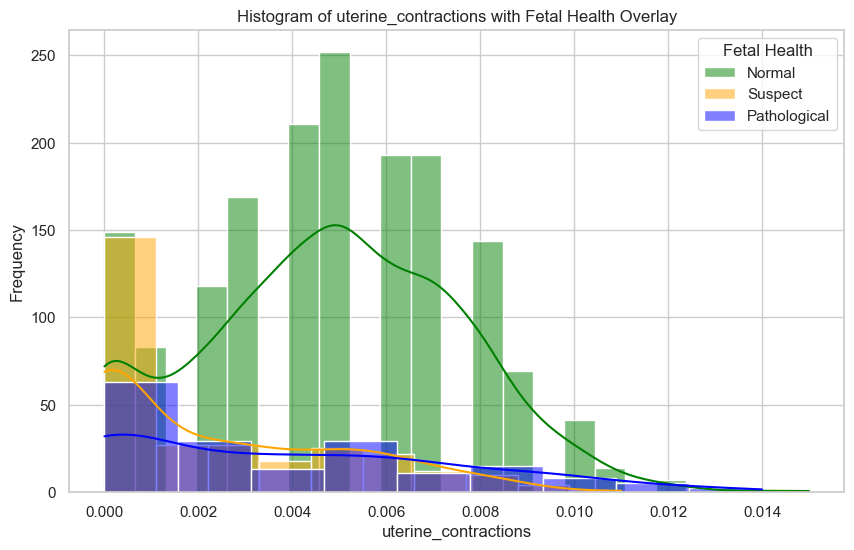

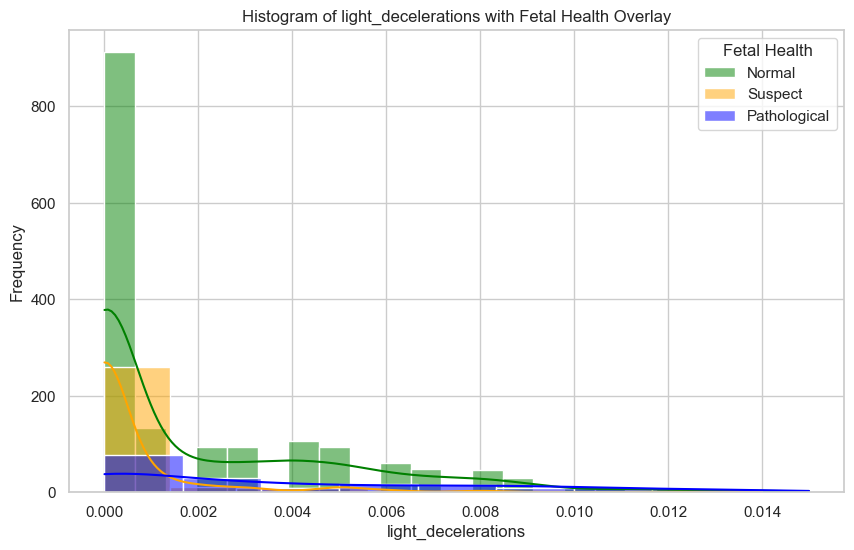

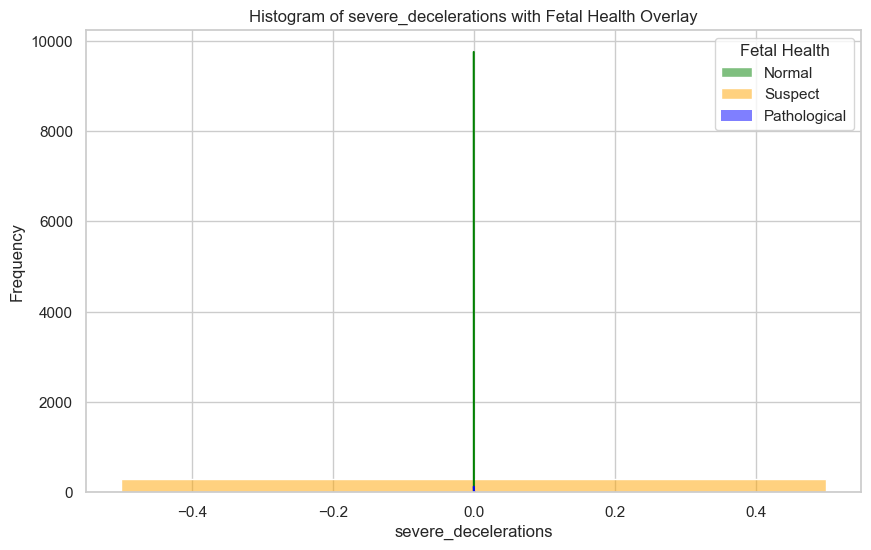

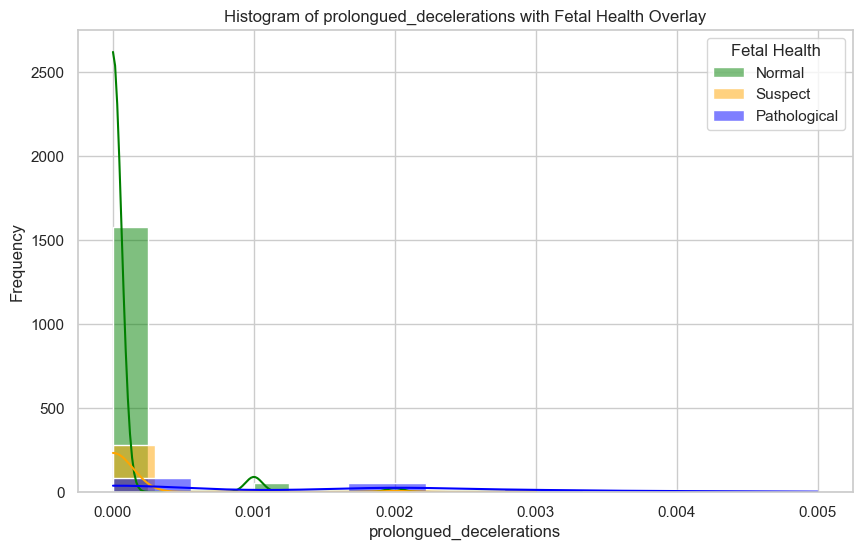

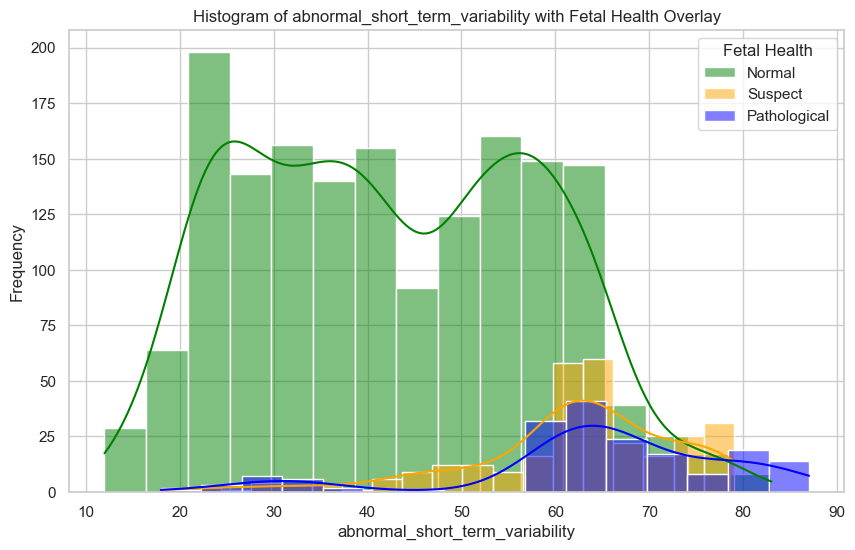

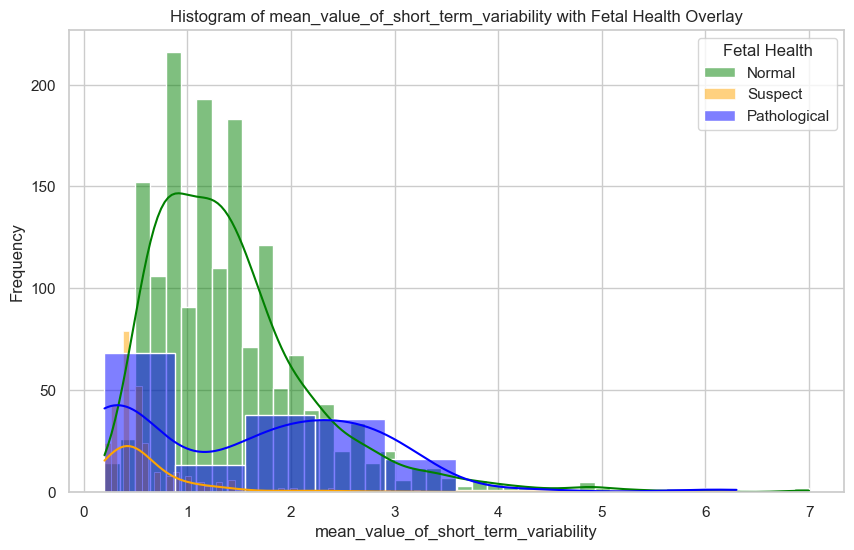

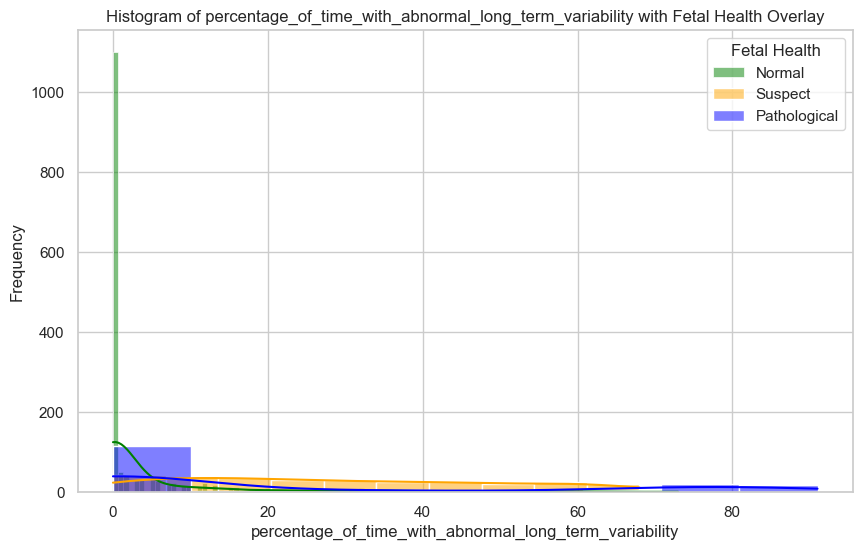

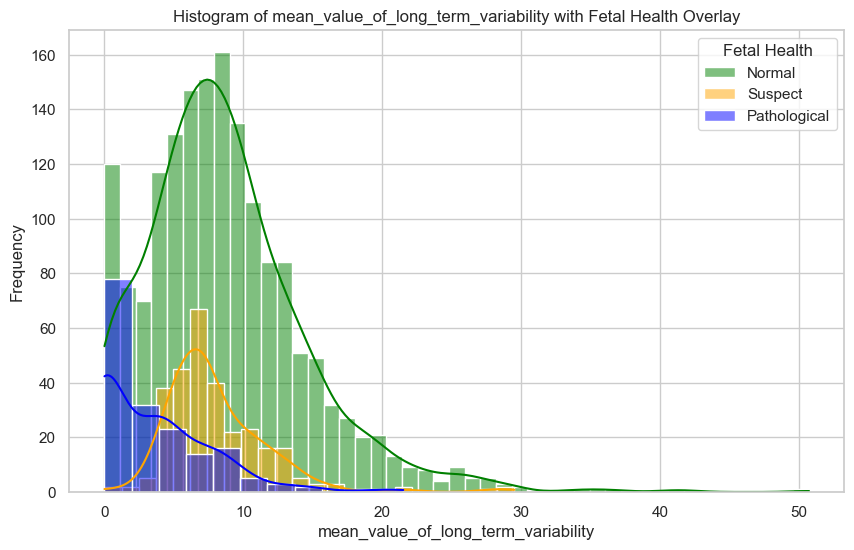

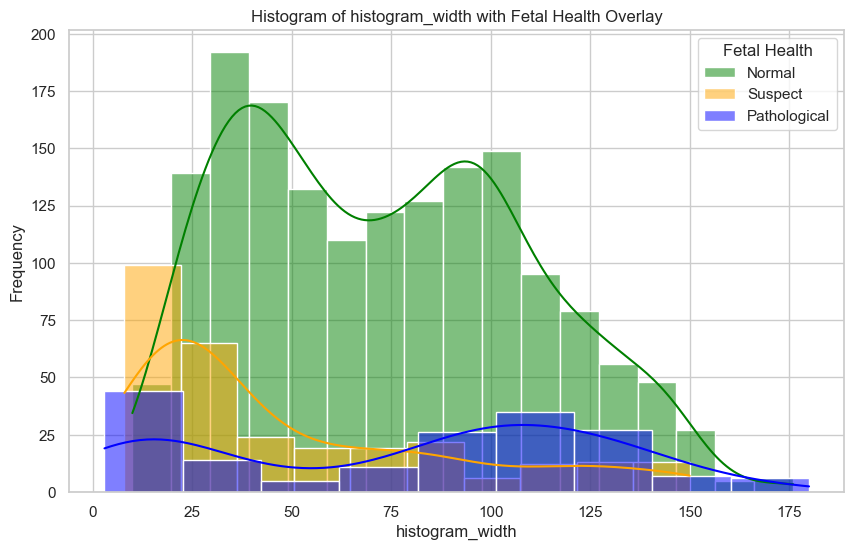

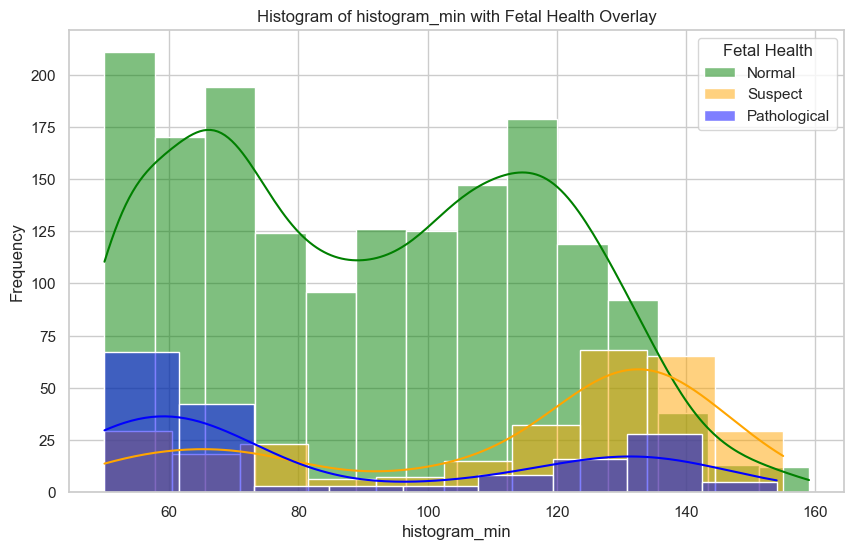

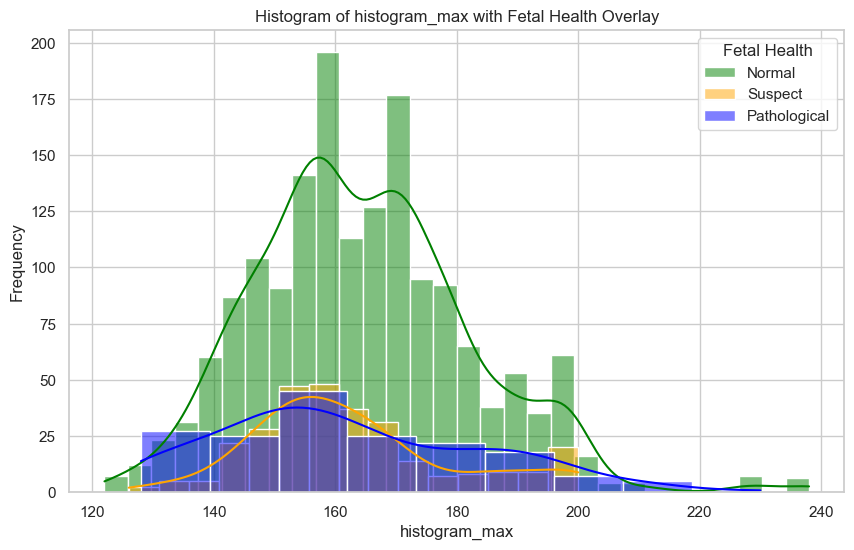

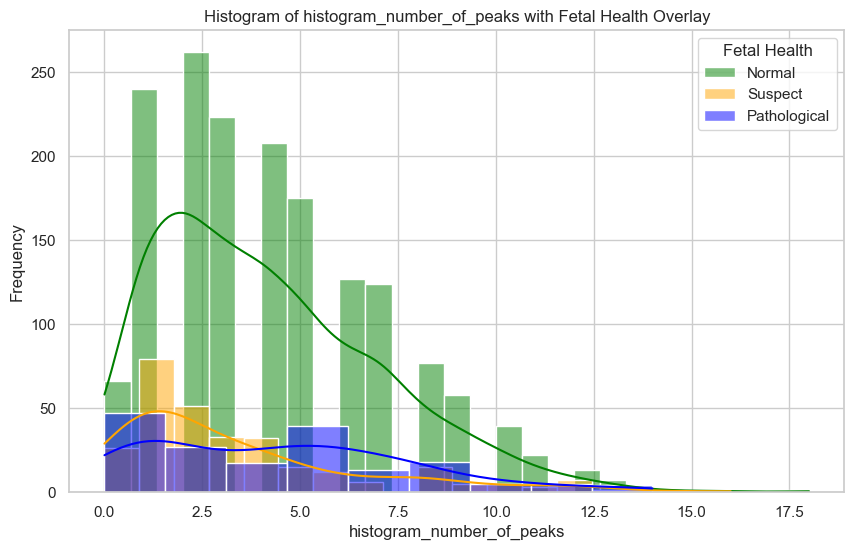

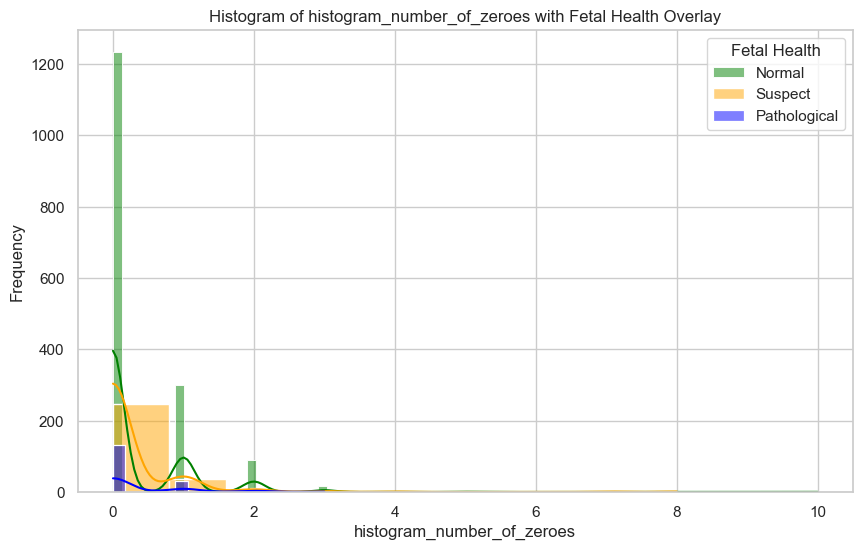

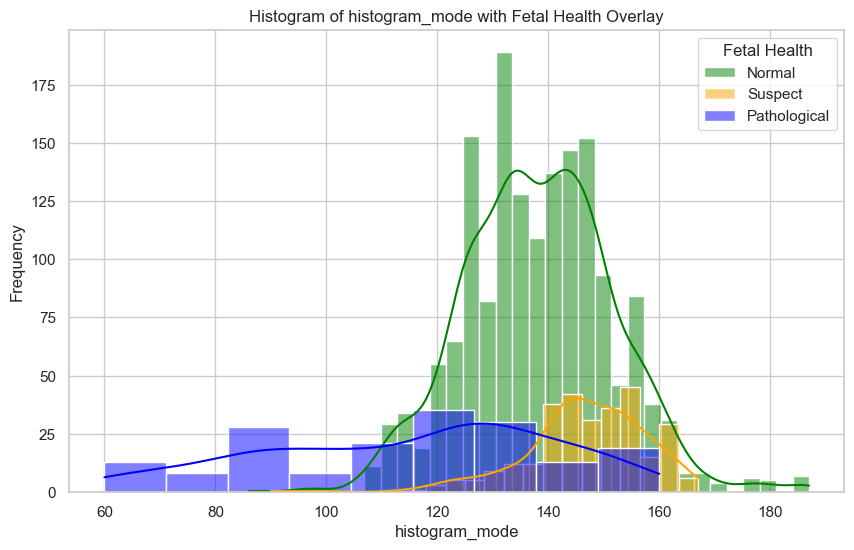

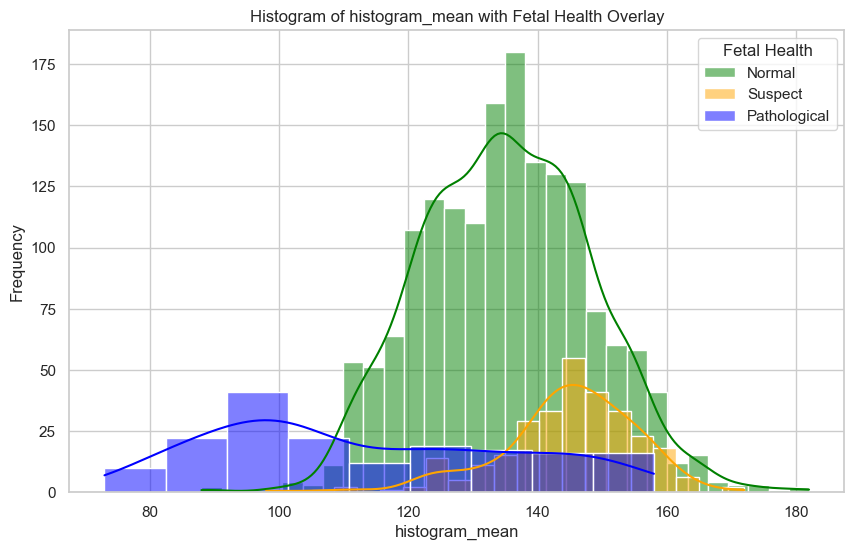

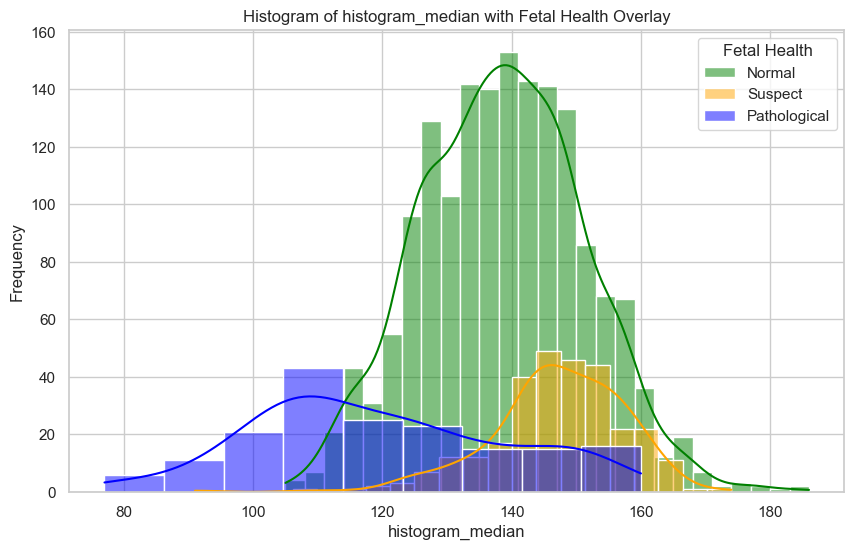

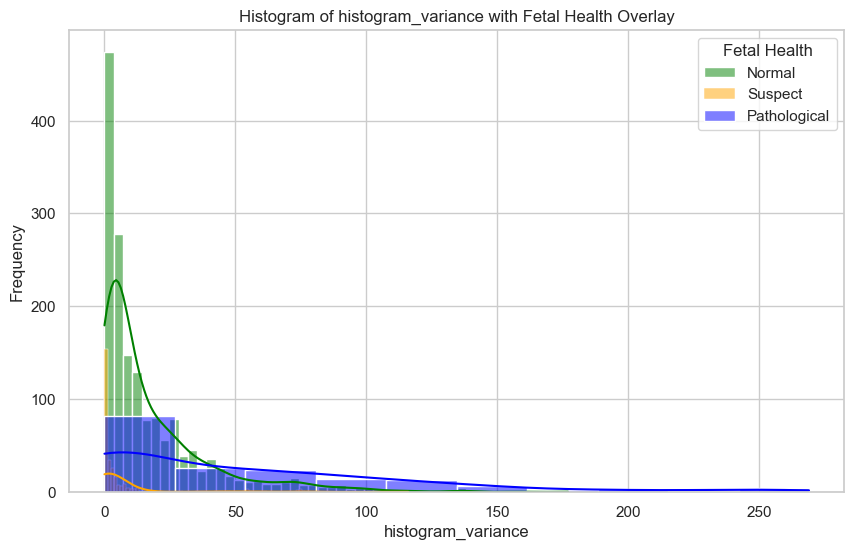

In [17]:
# Set the style
sns.set(style="whitegrid")

# Define colors for each category
colors = {'Normal': 'green', 'Suspect': 'orange', 'Pathological': 'blue'}

# Iterate over each numeric variable
for column in numeric_variables.columns:
    # Plot the histogram with overlay
    plt.figure(figsize=(10, 6))
    for category, color in colors.items():
        sns.histplot(data=foetal_health_df[foetal_health_df['fetal_health'] == category], x=column, color=color, label=category, kde=True)

    # Set labels and title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column} with Fetal Health Overlay')
    plt.legend(title='Fetal Health')

    # Show the plot
    plt.show()


- Most Suspect fetuses have baseline values tending towards the upper bound of the baseline value band.
- Most Normal fetuses are associated with normal distribution for mother's uterine contractions while Suspect and Pathological fetuses' observations are skewed to the right , with Pathological experiencing the highest conctractions per second.
- Both Suspect and Pathological fetuses exhibit fewer instances of abnormal short term variability than the Normal fetuses, but they have the largest variations.
- Pathological fetuses exhibit decreasing values of long term variability mean.
- Normal fetuses are seen to have the largest number of accelerations per second.

### Box Plots for Numeric Variables Range Assessment and Outlier Detection

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300')])

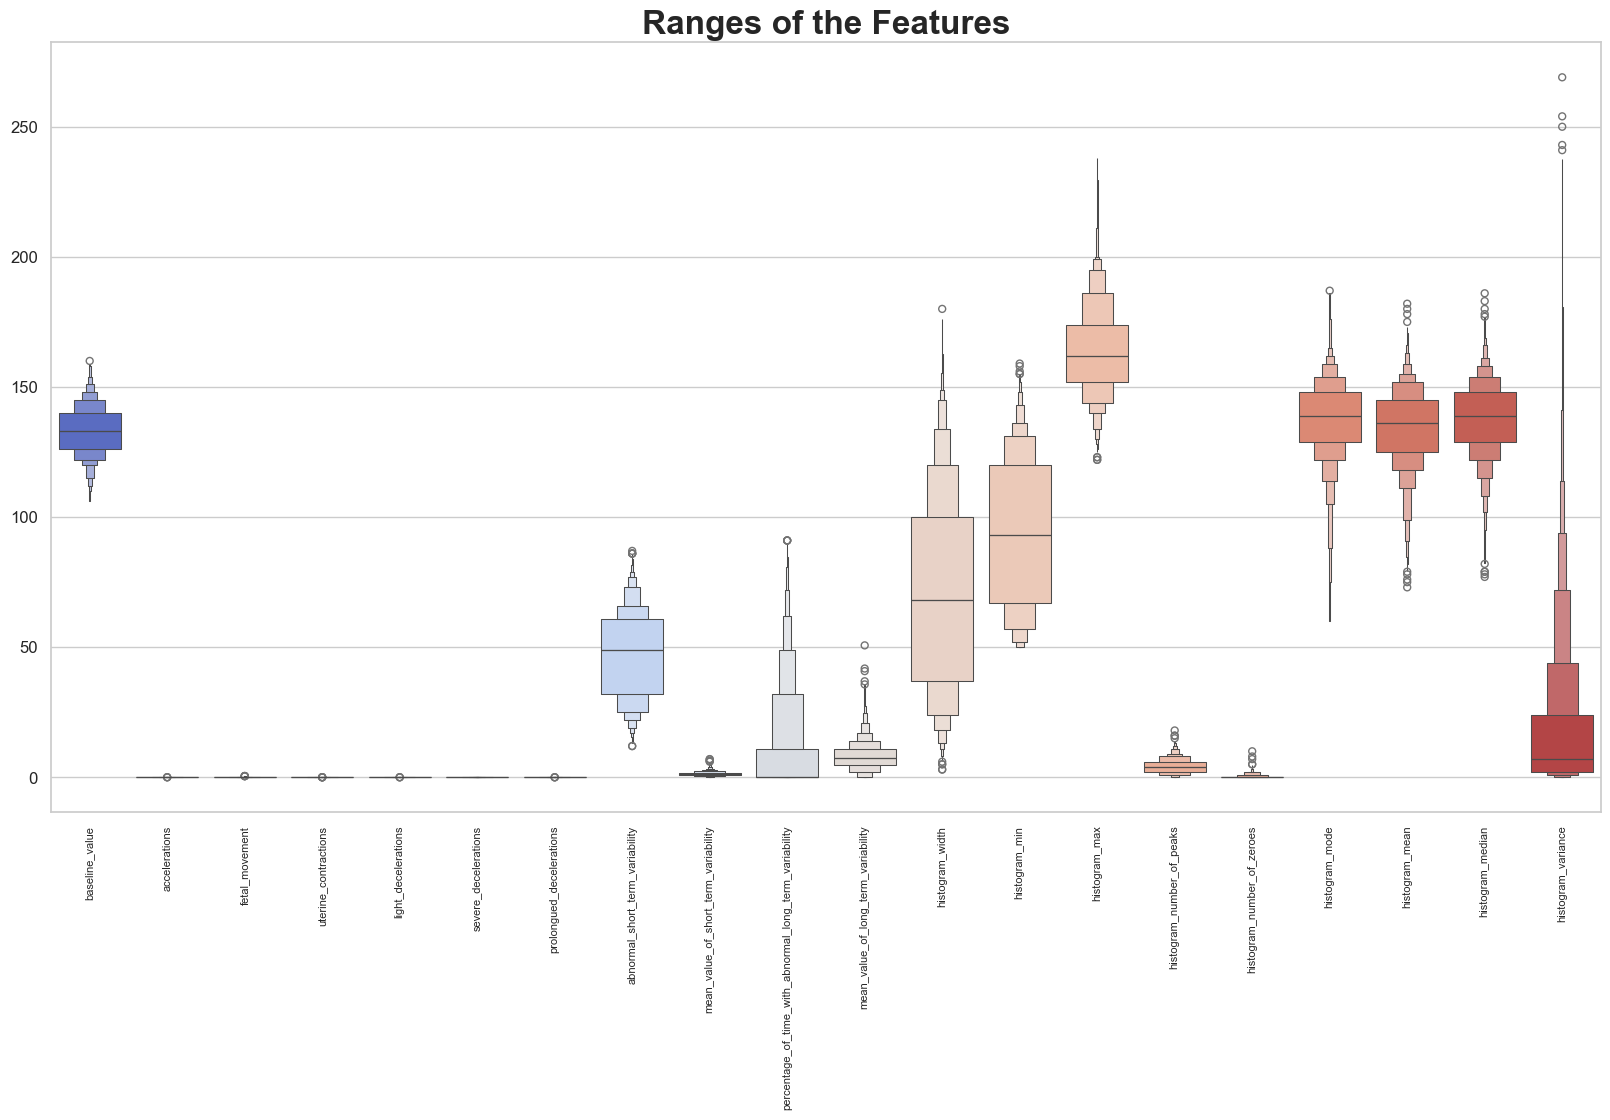

In [18]:
# Ranges of the features
plt.figure(figsize=(20, 10))
sns.boxenplot(data=numeric_variables, palette='coolwarm')

plt.title('Ranges of the Features',
          fontsize=24,
          fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=12)

- The features have significantly different ranges necessitating feature scaling to improves model convergence i.e., allowing models to efficiently find optimal parameters.
- There are  outliers on the dataset as indicated by observations whose values are outside the boxplot whiskers. 
- However, it is not quite a good idea to remove them yet even though we may end up with better statistics.
- The removal of outliers follows a judicious process and they can only be removed if in deed their occurrence is due to error.
- In this case, the results are the outcome of a CTG report so it is unlikely that this was a data entry error.
- The outliers will not be removed since their occurrence can not be confidently associated with error.

### Numeric Predictors Correlation Analysis

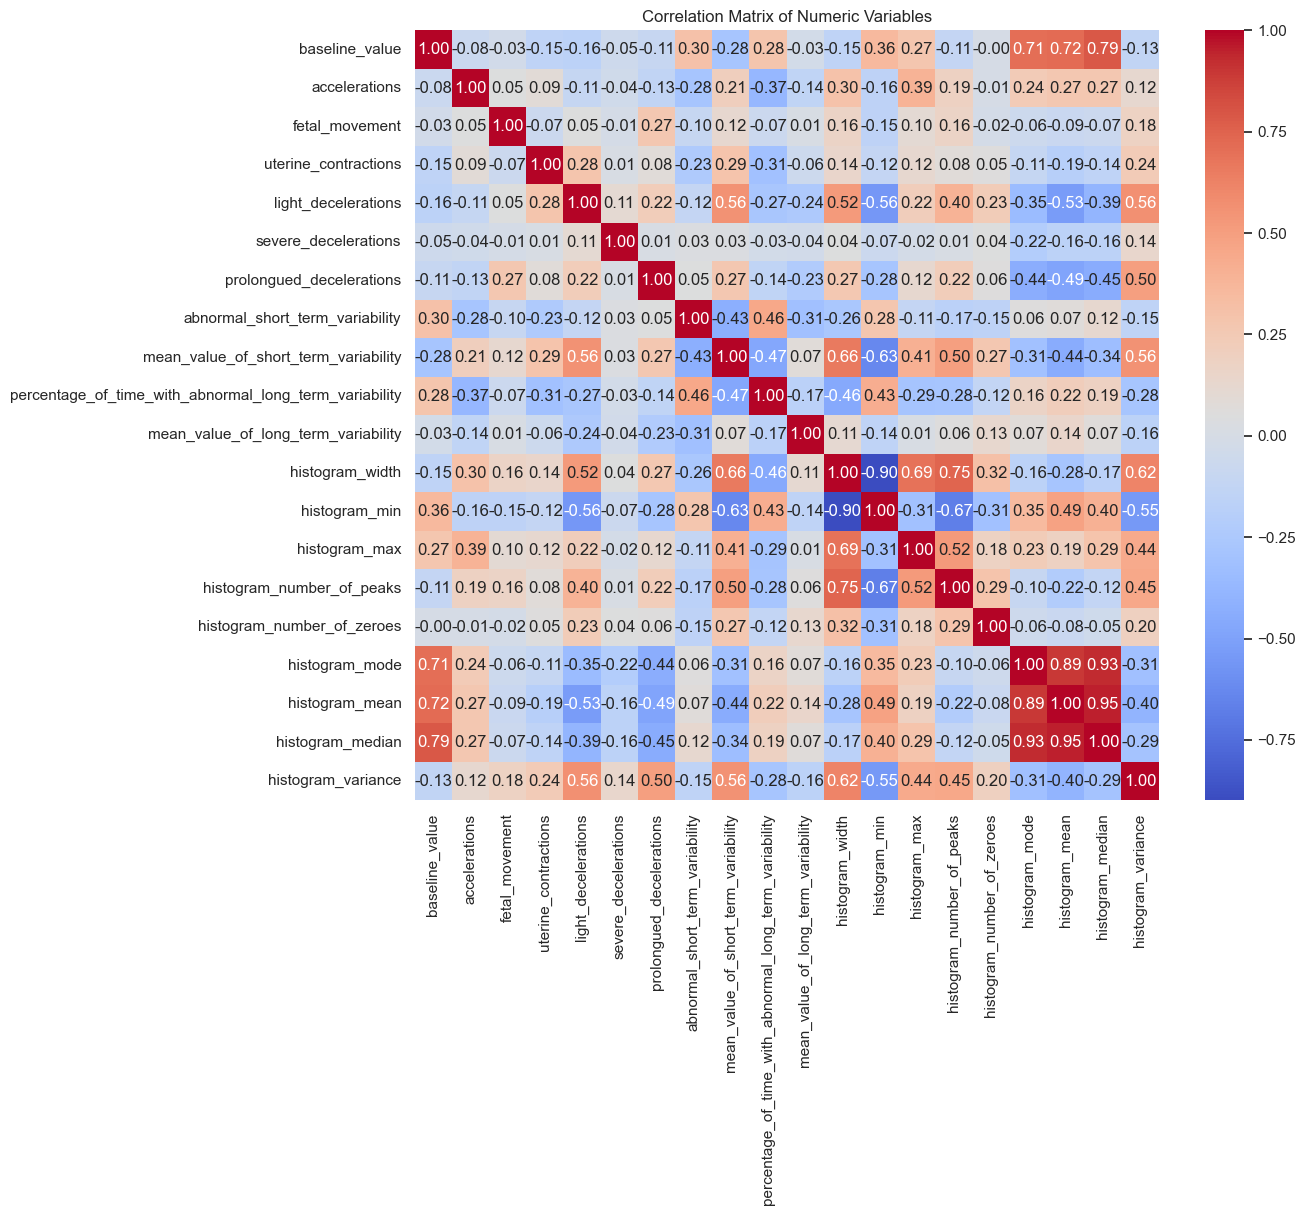

In [19]:
# Calculate correlation matrix
correlation_matrix = numeric_variables.corr()
# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

- The histogram parameters/histogram related variables exhibit high correlation (>0.85)
- High correlation can lead to the problem of multicollinearity (predictor variables are highly correlated)
- Multicollinearity increases model complexity, potentially leading to overfitting.

### Drop Highly Correlated Features

In [20]:
# Create a mask to identify highly correlated variables
corr_mask = correlation_matrix.abs() > 0.85

# Create an empty set to store variables to retain
variables_to_retain = set()

# Loop through the columns of the correlation matrix
for column in corr_mask.columns:
    # Find variables highly correlated with the current variable
    correlated_variables = corr_mask.index[corr_mask[column]].tolist()
    
    # Check if there are correlated variables and the current variable is not already dropped
    if correlated_variables and column not in variables_to_retain:
        # Retain the current variable and drop all correlated variables except the current one
        variables_to_retain.add(column)
        for correlated_variable in correlated_variables:
            if correlated_variable != column:
                variables_to_retain.discard(correlated_variable)

# Drop variables that are not retained
variables_to_drop = set(correlation_matrix.columns) - variables_to_retain

# Drop the variables from the DataFrame
df_dropped = numeric_variables.drop(columns=variables_to_drop)

# Print the variables retained after elimination
print("Variables retained after elimination:")
print(variables_to_retain)


Variables retained after elimination:
{'uterine_contractions', 'histogram_number_of_zeroes', 'mean_value_of_short_term_variability', 'light_decelerations', 'fetal_movement', 'histogram_number_of_peaks', 'baseline_value', 'abnormal_short_term_variability', 'accelerations', 'mean_value_of_long_term_variability', 'histogram_max', 'histogram_median', 'prolongued_decelerations', 'severe_decelerations', 'histogram_variance', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_min'}


In [21]:
print(variables_to_drop)

{'histogram_mode', 'histogram_mean', 'histogram_width'}


## Model Evaluation

In [22]:
# Drop the highly correlated variables
foetal_health_df.drop(columns=['histogram_mean', 'histogram_mode', 'histogram_width'], inplace=True)

### Data Splitting

In [23]:
# Splitting the data into features (X) and target variable (y)
X = foetal_health_df.drop(columns=['fetal_health'])  # Features
y = foetal_health_df['fetal_health']  # Target variable

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Printing the shapes of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (1479, 18) (1479,)
Test set shape: (634, 18) (634,)


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, 1143 to 869
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline_value                                          1479 non-null   int64  
 1   accelerations                                           1479 non-null   float64
 2   fetal_movement                                          1479 non-null   float64
 3   uterine_contractions                                    1479 non-null   float64
 4   light_decelerations                                     1479 non-null   float64
 5   severe_decelerations                                    1479 non-null   float64
 6   prolongued_decelerations                                1479 non-null   float64
 7   abnormal_short_term_variability                         1479 non-null   int64  
 8   mean_value_of_short_term_variability     

- Apply OneHotEncoder to the 'histogram_tendency' variable for the train set

In [25]:
# Separate the feature to be encoded
histogram_tendency = X_train[['histogram_tendency']]

# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
histogram_tendency_encoded = encoder.fit_transform(histogram_tendency)

# Convert encoded features to DataFrame
histogram_tendency_encoded_df = pd.DataFrame(histogram_tendency_encoded, columns=encoder.get_feature_names_out(['histogram_tendency']))


## Feature Standardization

- Standardization is a data preparation method that involves adjusting the input (features) by first centering them (subtracting the mean from each data point) 
- Then dividing them by the standard deviation, resulting in the data having a mean of 0 and a standard deviation of 1.

- standardized_val = ( input_value - mean ) / standard_deviation

- Assume you have a mean value of 10.4 and a standard deviation value of 4. To standardize the value of 15.9, put the given values into the equation as follows:

- standardized_val = ( 15.9 - 10.4 ) / 4
- standardized_val = ( 5.5 ) / 4
- standardized_val = 1.37

- StandardScaler: The StandardScaler class provided by Scikit Learn applies the standardization on the input (features) variable, making sure they have a mean of approximately 0 and a standard deviation of approximately 1.

- It adjusts the data to have a standardized distribution, making it suitable for modeling and ensuring that no single feature disproportionately influences the algorithm due to differences in scale.

### Scaling the Train Features

(array([-7.5, -5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5')])

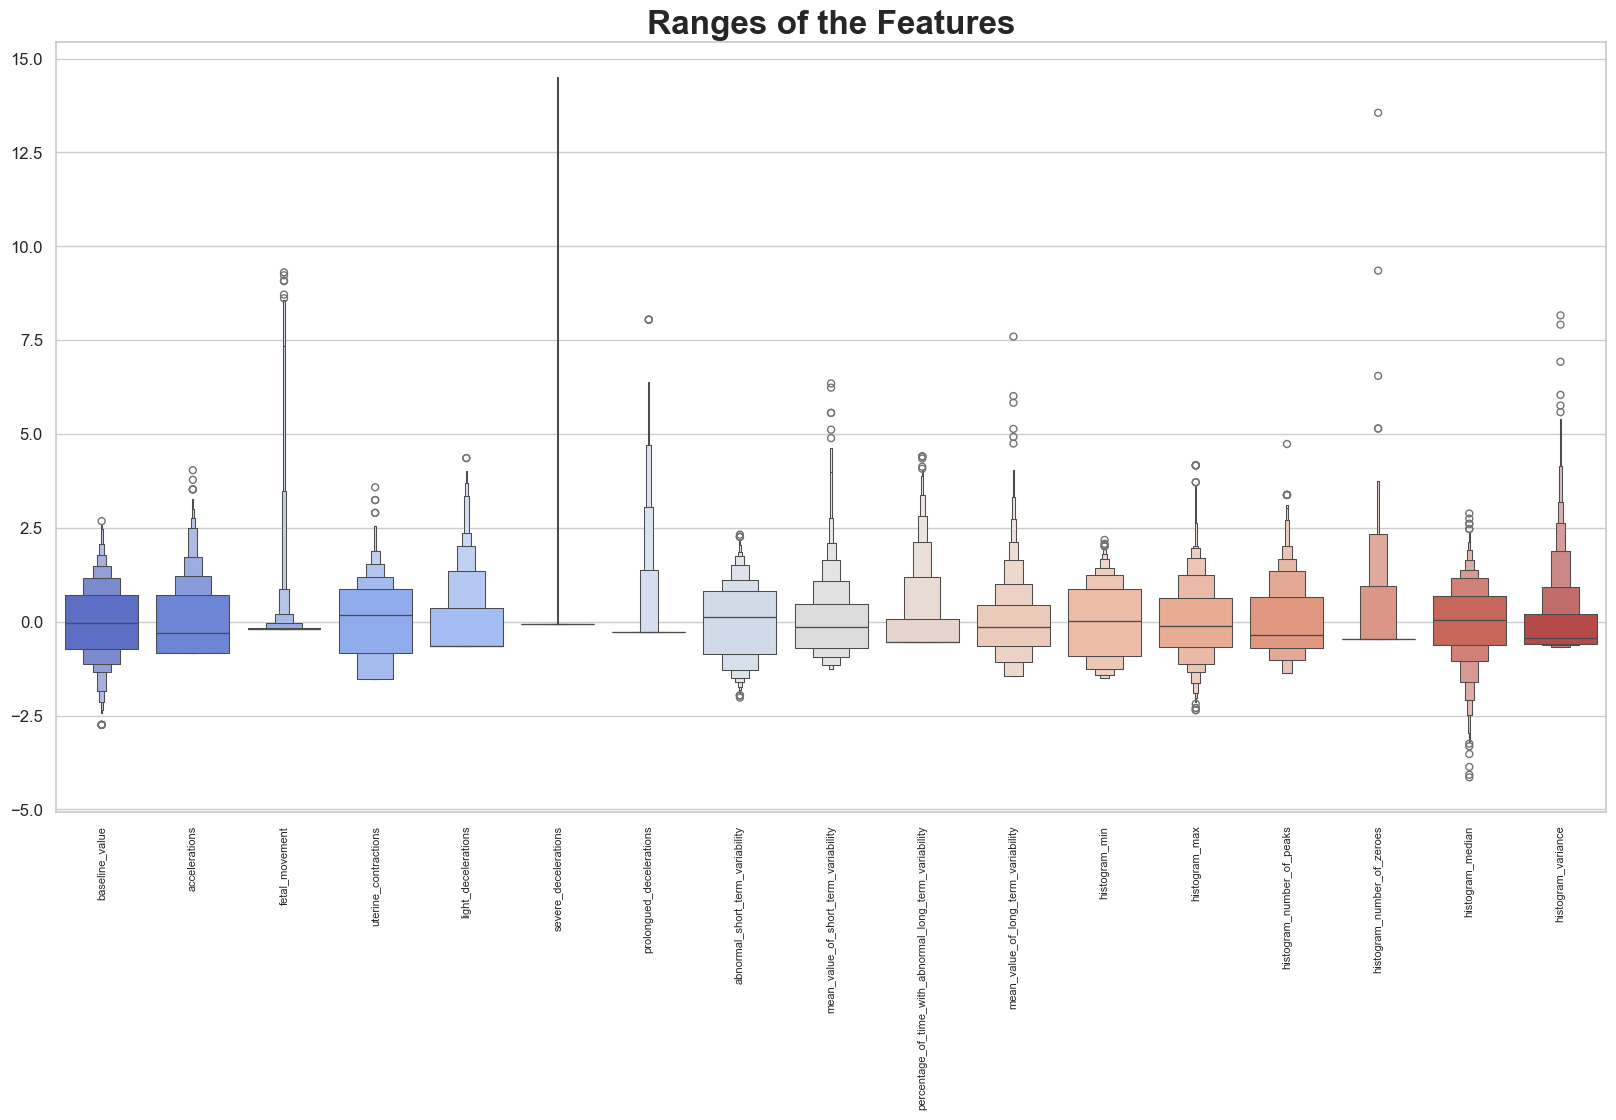

In [26]:
# Initialize StandardScaler
scaler = StandardScaler()
#Drop 'histogram_tendency'
X_train = X_train.drop('histogram_tendency', axis=1)
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Convert the scaled array back to a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Plot box plots for scaled features
plt.figure(figsize=(20, 10))
sns.boxenplot(data=X_train_scaled, palette='coolwarm')

plt.title('Ranges of the Features',
          fontsize=24,
          fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=12)

In [27]:
# Combine encoded features with the scaled features
X_train_encoded_scaled = pd.concat([X_train_scaled, histogram_tendency_encoded_df], axis=1)

# Display the final DataFrame
print(X_train_encoded_scaled)

      baseline_value  accelerations  fetal_movement  uterine_contractions  \
0          -1.140907       0.200165       -0.202077              0.520864   
1          -1.844535      -0.055486       -0.202077              1.540304   
2           1.472570       0.455817       -0.202077              0.181050   
3           0.065313      -0.311138       -0.202077              1.880118   
4          -0.336760       0.711468        7.309757             -0.158763   
...              ...            ...             ...                   ...   
1474       -0.135724       0.967120       -0.202077              1.880118   
1475       -1.140907      -0.822441       -0.202077             -0.498577   
1476       -1.140907       0.200165       -0.202077              0.181050   
1477        0.467387      -0.311138       -0.202077              0.860677   
1478        0.266350       0.967120       -0.202077              0.181050   

      light_decelerations  severe_decelerations  prolongued_decelerations  

### Encoding and Scaling the Test Features

In [28]:
# Separate the feature to be encoded
histogram_tendency = X_test[['histogram_tendency']]

# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
histogram_tendency_encoded = encoder.fit_transform(histogram_tendency)

# Convert encoded features to DataFrame
histogram_tendency_encoded_df = pd.DataFrame(histogram_tendency_encoded, columns=encoder.get_feature_names_out(['histogram_tendency']))

(array([-7.5, -5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. ]),
 [Text(0, -7.5, '−7.5'),
  Text(0, -5.0, '−5.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0')])

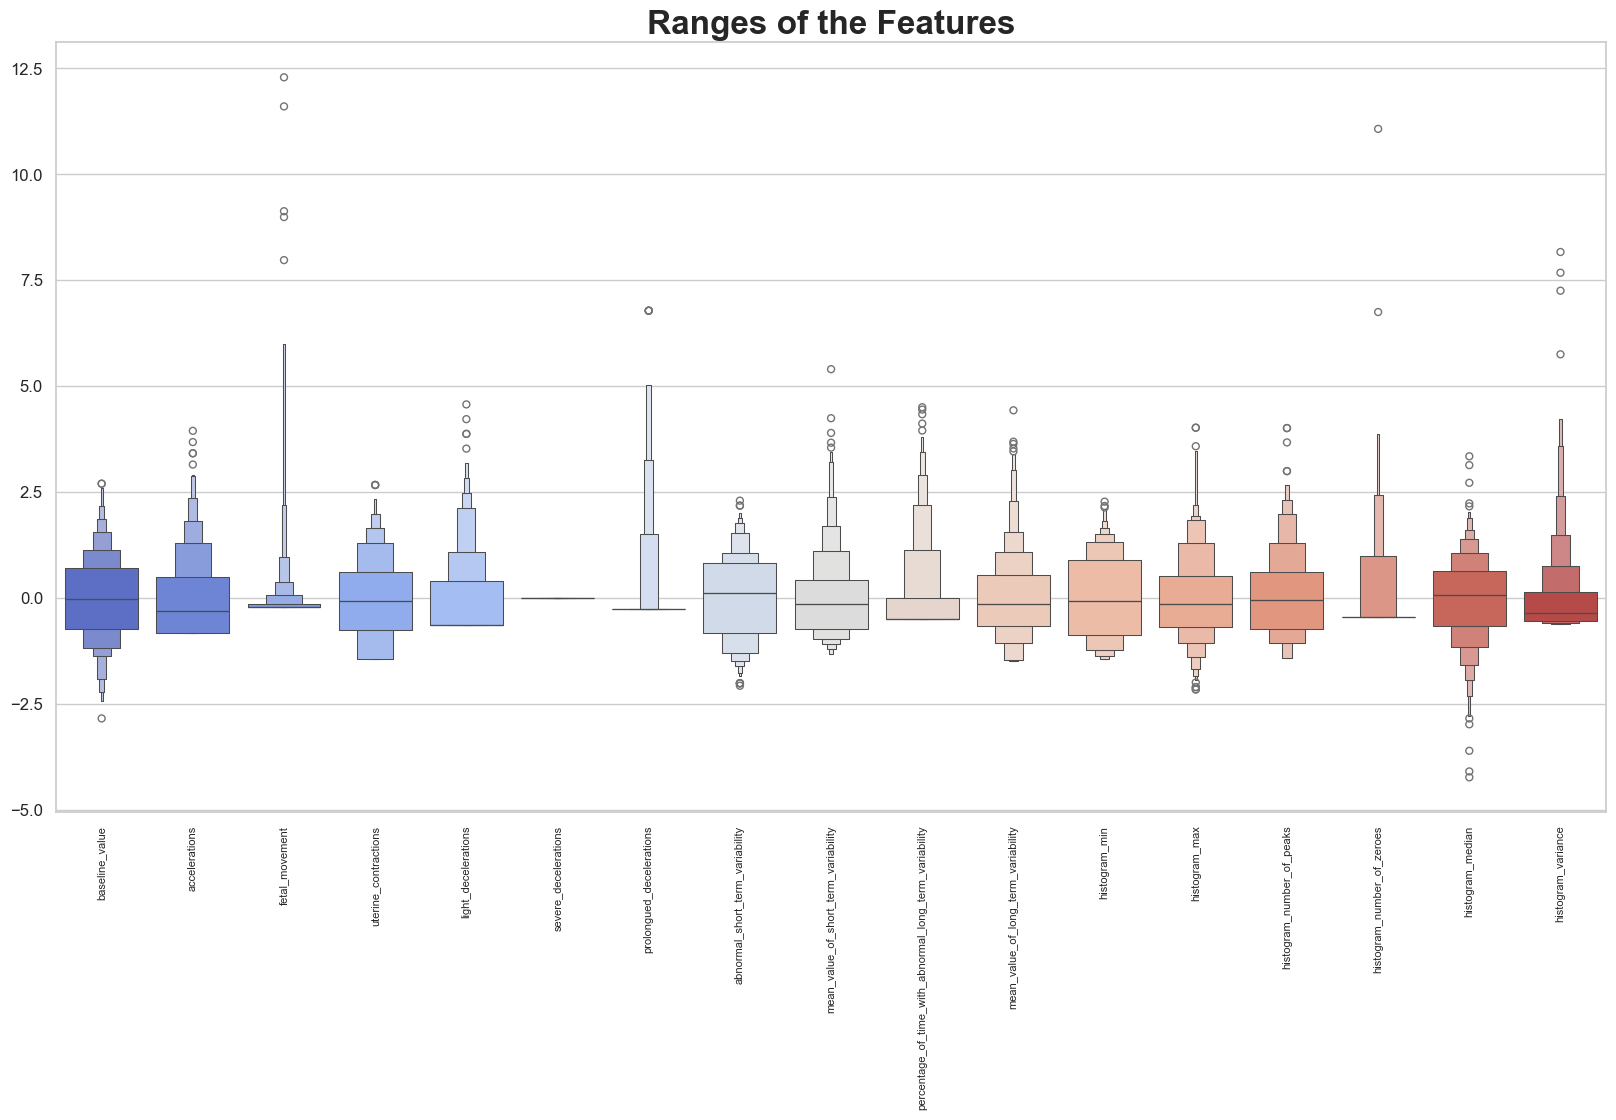

In [29]:
# Initialize StandardScaler
scaler = StandardScaler()
#Drop 'histogram_tendency'
X_test = X_test.drop('histogram_tendency', axis=1)
# Fit and transform the training data
X_test_scaled = scaler.fit_transform(X_test)

# Convert the scaled array back to a DataFrame
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Plot box plots for scaled features
plt.figure(figsize=(20, 10))
sns.boxenplot(data=X_test_scaled, palette='coolwarm')

plt.title('Ranges of the Features',
          fontsize=24,
          fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=12)

In [30]:
# Combine encoded features with the scaled features
X_test_encoded_scaled = pd.concat([X_test_scaled, histogram_tendency_encoded_df], axis=1)

- Train and Test features are encoded and scaled separately to avoid data leakage that can lead to overfitting on the train data

### Model Training

In [31]:
# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(verbose=False)

# Train the CatBoost model
catboost_model.fit(X_train_encoded_scaled, y_train)

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train_encoded_scaled, y_train)

# Initialize Multiclass Logistic Regression model
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the Multiclass Logistic Regression model
logistic_regression_model.fit(X_train_encoded_scaled, y_train)


LogisticRegression(multi_class='multinomial')

### Model Performance

In [32]:
# Predicting on the test data for CatBoost model
y_test_pred_catboost = catboost_model.predict(X_test_encoded_scaled)

# Print classification report for CatBoost model
print("CatBoost Model:")
print(classification_report(y_test, y_test_pred_catboost))
print()

# Predicting on the test data for Random Forest model
y_test_pred_rf = rf_model.predict(X_test_encoded_scaled)

# Print classification report for Random Forest model
print("Random Forest Model:")
print(classification_report(y_test, y_test_pred_rf))
print()

# Predicting on the test data for Multiclass Logistic Regression model
y_test_pred_logistic_regression = logistic_regression_model.predict(X_test_encoded_scaled)

# Print classification report for Multiclass Logistic Regression model
print("Multiclass Logistic Regression Model:")
print(classification_report(y_test, y_test_pred_logistic_regression))

CatBoost Model:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       497
Pathological       0.92      0.96      0.94        47
     Suspect       0.94      0.80      0.86        90

    accuracy                           0.96       634
   macro avg       0.94      0.92      0.93       634
weighted avg       0.96      0.96      0.96       634


Random Forest Model:
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98       497
Pathological       0.90      0.94      0.92        47
     Suspect       0.93      0.76      0.83        90

    accuracy                           0.95       634
   macro avg       0.93      0.89      0.91       634
weighted avg       0.95      0.95      0.95       634


Multiclass Logistic Regression Model:
              precision    recall  f1-score   support

      Normal       0.95      0.97      0.96       497
Pathological       0.81      0.83      0.82        4

- The best model based weighted average precsion and recall metrics is Catboost at 96%

## Model Optimization

### Feature Engineering

##### Feature Importance

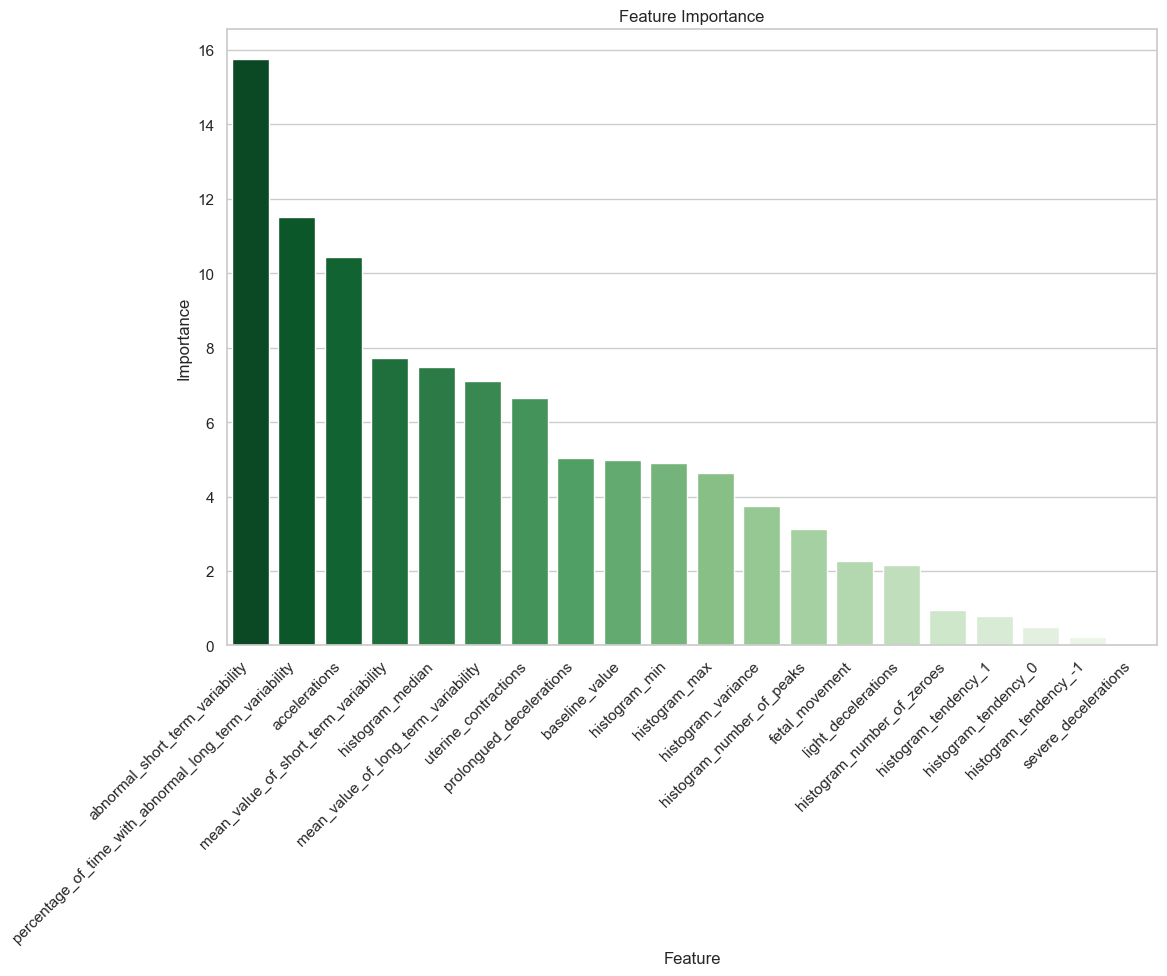

In [33]:
# Get feature importances from the CatBoost model
feature_importance = catboost_model.feature_importances_

# Get feature names
feature_names = X_train_encoded_scaled.columns

# Sort indices by importance
sorted_indices = np.argsort(feature_importance)[::-1]

# Sort feature names accordingly
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': feature_importance[sorted_indices]})

# Plot feature importance using Seaborn with color mapping
plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Importance', data=importance_df, palette=sns.color_palette("Greens_r", n_colors=len(importance_df)), hue='Feature', dodge=False, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

### 3 Most Important Features Boxplots

C:\Users\kigosn\AppData\Local\Temp\ipykernel_4312\2753766121.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fetal_health', y=feature, data=important_features_df, palette=palette_colors)


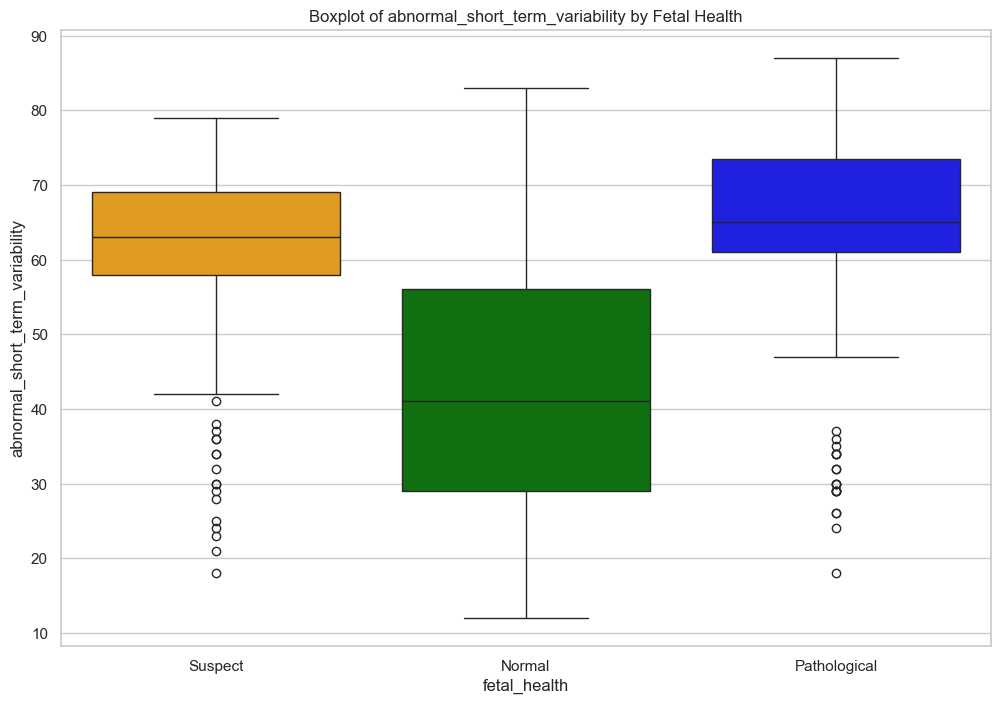

C:\Users\kigosn\AppData\Local\Temp\ipykernel_4312\2753766121.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fetal_health', y=feature, data=important_features_df, palette=palette_colors)


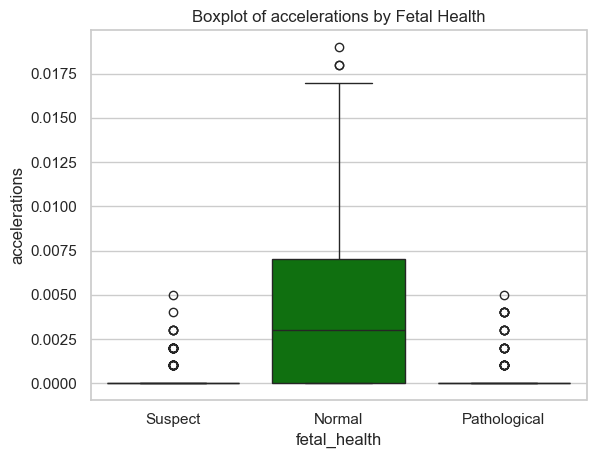

C:\Users\kigosn\AppData\Local\Temp\ipykernel_4312\2753766121.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fetal_health', y=feature, data=important_features_df, palette=palette_colors)


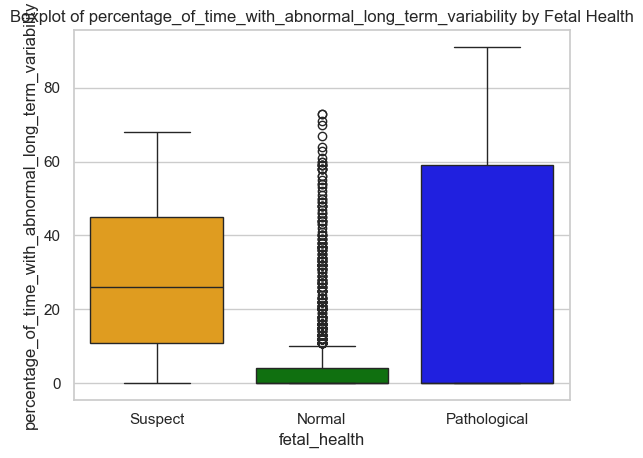

In [34]:
# Select the three most important features from foetal_health_df
important_features_df = foetal_health_df[['abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'accelerations', 'fetal_health']]

# Assign colors to the target variable classes
palette_colors = {'Normal': 'green', 'Suspect': 'orange', 'Pathological': 'blue'}

# Plot box plots for each important feature by the target variable with assigned colors
plt.figure(figsize=(12, 8))
for feature in ['abnormal_short_term_variability', 'accelerations', 'percentage_of_time_with_abnormal_long_term_variability']:
    sns.boxplot(x='fetal_health', y=feature, data=important_features_df, palette=palette_colors)
    plt.title(f'Boxplot of {feature} by Fetal Health')
    plt.show()

- The Suspect and Pathological categories experience more abnormal short term variability (Fluctuations in FHR) than the Normal category
- The Normal category exhibits more accelerations (number of temporary increases in FHR) than Suspect and Pathological

6. **Variability**:
   - **What It Measures**: Fluctuations in FHR.
   - **Why It Matters**: Variability reflects the adaptability of the fetal nervous system.
   - **Interpretation**: Moderate variability is normal; reduced variability may signal distress.


2. **Accelerations**:
   - **What They Are**: The number of temporary increases in FHR.
   - **Why They Matter**: Accelerations are positive signs, showing fetal responsiveness.
   - **Interpretation**: More accelerations are reassuring.

### Drop Features Whose Value of Importance is Less than 4

In [35]:
# Filter importance_df to keep only features with importance >= 4
important_features_df = importance_df[importance_df['Importance'] >= 4]

# Print the filtered DataFrame
print(important_features_df)


                                              Feature  Importance
0                     abnormal_short_term_variability   15.758135
1   percentage_of_time_with_abnormal_long_term_var...   11.515400
2                                       accelerations   10.436357
3                mean_value_of_short_term_variability    7.719702
4                                    histogram_median    7.487668
5                 mean_value_of_long_term_variability    7.105717
6                                uterine_contractions    6.656271
7                            prolongued_decelerations    5.021584
8                                      baseline_value    4.987112
9                                       histogram_min    4.890829
10                                      histogram_max    4.622987


### Drop From Train Set

In [36]:
# Get the names of important features
important_feature_names = important_features_df['Feature'].tolist()

# Filter X_train_enocoded_scaled to keep only important features
X_train_encoded_scaled_important = X_train_encoded_scaled[important_feature_names].copy()

# Print the first few rows of X_train_scaled_important
print(X_train_encoded_scaled_important.head())


   abnormal_short_term_variability  \
0                        -1.502090   
1                        -1.502090   
2                        -1.154758   
3                        -1.212647   
4                        -1.617867   

   percentage_of_time_with_abnormal_long_term_variability  accelerations  \
0                                          -0.546242            0.200165   
1                                          -0.546242           -0.055486   
2                                          -0.111365            0.455817   
3                                          -0.002646           -0.311138   
4                                          -0.546242            0.711468   

   mean_value_of_short_term_variability  histogram_median  \
0                              0.408071         -0.838696   
1                              0.408071         -0.907597   
2                              0.183999          1.297246   
3                              0.520106         -0.080781   
4        

### Drop From Test Set

In [37]:
# Get the names of important features
important_feature_names = important_features_df['Feature'].tolist()

# Filter X_test_scaled to keep only important features
X_test_encoded_scaled_important = X_test_encoded_scaled[important_feature_names].copy()

# Print the first few rows of X_train_scaled_important
print(X_test_encoded_scaled_important.head())

   abnormal_short_term_variability  \
0                         1.706403   
1                         0.761651   
2                        -0.419290   
3                         0.820698   
4                         0.112133   

   percentage_of_time_with_abnormal_long_term_variability  accelerations  \
0                                          -0.506508           -0.297324   
1                                          -0.506508            0.498049   
2                                          -0.506508            2.619045   
3                                           2.355282           -0.827573   
4                                          -0.341404           -0.827573   

   mean_value_of_short_term_variability  histogram_median  \
0                             -0.848499          1.189048   
1                             -0.038510         -1.244092   
2                             -0.038510         -0.131800   
3                             -0.732786          0.424347   
4        

### Train the models with the important features only

In [38]:
# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(verbose=False)

# Train the CatBoost model
catboost_model.fit(X_train_encoded_scaled_important, y_train)

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train_encoded_scaled_important, y_train)

# Initialize Multiclass Logistic Regression model
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the Multiclass Logistic Regression model
logistic_regression_model.fit(X_train_encoded_scaled_important, y_train)

LogisticRegression(multi_class='multinomial')

### Test the models trained by important features

In [39]:
# Predicting on the test data for CatBoost model
y_test_pred_catboost = catboost_model.predict(X_test_encoded_scaled_important)

# Print classification report for CatBoost model
print("CatBoost Model:")
print(classification_report(y_test, y_test_pred_catboost))
print()

# Predicting on the test data for Random Forest model
y_test_pred_rf = rf_model.predict(X_test_encoded_scaled_important)

# Print classification report for Random Forest model
print("Random Forest Model:")
print(classification_report(y_test, y_test_pred_rf))
print()

# Predicting on the test data for Multiclass Logistic Regression model
y_test_pred_logistic_regression = logistic_regression_model.predict(X_test_encoded_scaled_important)

# Print classification report for Multiclass Logistic Regression model
print("Multiclass Logistic Regression Model:")
print(classification_report(y_test, y_test_pred_logistic_regression))

CatBoost Model:
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98       497
Pathological       0.90      0.94      0.92        47
     Suspect       0.92      0.78      0.84        90

    accuracy                           0.95       634
   macro avg       0.93      0.90      0.91       634
weighted avg       0.95      0.95      0.95       634


Random Forest Model:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       497
Pathological       0.90      0.94      0.92        47
     Suspect       0.91      0.78      0.84        90

    accuracy                           0.95       634
   macro avg       0.92      0.90      0.91       634
weighted avg       0.95      0.95      0.95       634


Multiclass Logistic Regression Model:
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.96       497
Pathological       0.80      0.74      0.77        4

- Weighted average f1-score for multiclass logistic regression gained by 1% while that of CatBoost and Random Forest dropped by the same after dropping highly correlated features.
- The weighted average precision and recall for Random Forest remained unchanged while that of Catboost dropped by 1%
- This means that the dropped features were not adding any significant information to the models.
- Could Over-Sampling of the minority classes boost the results?

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [40]:
smote = SMOTE(random_state=20)

# Perform SMOTE on X_train_scaled_important
X_train_encoded_scaled_important_resampled, y_train_resampled = smote.fit_resample(X_train_encoded_scaled_important, y_train)

In [41]:
# Initialize CatBoost classifier
catboost_model = CatBoostClassifier(verbose=False)

# Train the CatBoost model
catboost_model.fit(X_train_encoded_scaled_important_resampled, y_train_resampled)

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train_encoded_scaled_important_resampled, y_train_resampled)

# Initialize Multiclass Logistic Regression model
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the Multiclass Logistic Regression model
logistic_regression_model.fit(X_train_encoded_scaled_important_resampled, y_train_resampled)


LogisticRegression(multi_class='multinomial')

In [42]:
# Predicting on the test data for CatBoost model
y_test_pred_catboost = catboost_model.predict(X_test_encoded_scaled_important)

# Print classification report for CatBoost model
print("CatBoost Model:")
print(classification_report(y_test, y_test_pred_catboost))
print()

# Predicting on the test data for Random Forest model
y_test_pred_rf = rf_model.predict(X_test_encoded_scaled_important)

# Print classification report for Random Forest model
print("Random Forest Model:")
print(classification_report(y_test, y_test_pred_rf))
print()

# Predicting on the test data for Multiclass Logistic Regression model
y_test_pred_logistic_regression = logistic_regression_model.predict(X_test_encoded_scaled_important)

# Print classification report for Multiclass Logistic Regression model
print("Multiclass Logistic Regression Model:")
print(classification_report(y_test, y_test_pred_logistic_regression))

CatBoost Model:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97       497
Pathological       0.88      0.94      0.91        47
     Suspect       0.77      0.88      0.82        90

    accuracy                           0.94       634
   macro avg       0.88      0.92      0.90       634
weighted avg       0.94      0.94      0.94       634


Random Forest Model:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       497
Pathological       0.79      0.96      0.87        47
     Suspect       0.77      0.80      0.79        90

    accuracy                           0.93       634
   macro avg       0.85      0.90      0.87       634
weighted avg       0.93      0.93      0.93       634


Multiclass Logistic Regression Model:
              precision    recall  f1-score   support

      Normal       0.99      0.87      0.93       497
Pathological       0.65      0.91      0.76        4

- SMOTE dropped the weighted average f1-score for all candidate models

## Hyperparameter Tuning of the Best 2 Models (CatBoost and Random Forest)

In [43]:
# Define parameter grids for each model
catboost_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'iterations': [100, 200, 300]
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for each model
catboost_grid = GridSearchCV(CatBoostClassifier(verbose=False), catboost_params, cv=5)
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)

# Fit the GridSearchCV objects
catboost_grid.fit(X_train_encoded_scaled_important, y_train)
rf_grid.fit(X_train_encoded_scaled_important, y_train)

# Get the best parameters and score for each model
print("CatBoost Best Parameters:", catboost_grid.best_params_)
print("CatBoost Best Score:", catboost_grid.best_score_)
print()
print("Random Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best Score:", rf_grid.best_score_)
print()

CatBoost Best Parameters: {'depth': 7, 'iterations': 300, 'learning_rate': 0.1}
CatBoost Best Score: 0.939141090242785

Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Best Score: 0.9357581310123683



In [44]:
# Predicting on the test data for CatBoost model using best parameters
y_test_pred_catboost = catboost_grid.best_estimator_.predict(X_test_encoded_scaled_important)

# Print classification report for CatBoost model
print("CatBoost Model:")
print(classification_report(y_test, y_test_pred_catboost))
print()

# Predicting on the test data for Random Forest model using best parameters
y_test_pred_rf = rf_grid.best_estimator_.predict(X_test_encoded_scaled_important)

# Print classification report for Random Forest model
print("Random Forest Model:")
print(classification_report(y_test, y_test_pred_rf))
print()


CatBoost Model:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       497
Pathological       0.90      0.94      0.92        47
     Suspect       0.91      0.79      0.85        90

    accuracy                           0.96       634
   macro avg       0.93      0.90      0.91       634
weighted avg       0.95      0.96      0.95       634


Random Forest Model:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       497
Pathological       0.88      0.91      0.90        47
     Suspect       0.90      0.78      0.83        90

    accuracy                           0.95       634
   macro avg       0.91      0.89      0.90       634
weighted avg       0.95      0.95      0.95       634




- The weighted average f1-score for Random Forest and CatBoost remained fairly unchanged after hyperparameter tuning

## Dataset with Sample Predictions

In [45]:
len(y_test_pred_catboost),len(y_test),len(X_test)

(634, 634, 634)

In [46]:
# Convert y_test_pred_catboost to DataFrame
y_test_pred_df = pd.DataFrame(y_test_pred_catboost, columns=['Predicted_Labels'], index=X_test.index)

# Concatenate actual labels and predicted labels
merged_df = pd.concat([y_test, y_test_pred_df], axis=1)

# Concatenate feature data with the labels
final_df = pd.concat([X_test, merged_df], axis=1)

# Display the final DataFrame
print(final_df)


      baseline_value  accelerations  fetal_movement  uterine_contractions  \
601              144          0.002           0.010                 0.002   
2005             125          0.005           0.002                 0.006   
427              120          0.013           0.006                 0.003   
291              142          0.000           0.006                 0.000   
197              145          0.000           0.000                 0.002   
...              ...            ...             ...                   ...   
1750             134          0.005           0.002                 0.002   
948              142          0.006           0.000                 0.001   
523              158          0.010           0.029                 0.003   
817              152          0.000           0.000                 0.002   
339              133          0.000           0.000                 0.000   

      light_decelerations  severe_decelerations  prolongued_decelerations  

In [47]:
final_df.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_median,histogram_variance,fetal_health,Predicted_Labels
601,144,0.002,0.010,0.002,0.000,0.0,0.0,76,0.6,0,11.8,126,180,2,0,155,5,Suspect,Normal
2005,125,0.005,0.002,0.006,0.009,0.0,0.0,60,1.3,0,7.5,68,164,6,1,120,34,Normal,Normal
427,120,0.013,0.006,0.003,0.000,0.0,0.0,40,1.3,0,7.1,68,157,5,1,136,9,Normal,Normal
291,142,0.000,0.006,0.000,0.000,0.0,0.0,61,0.7,52,12.2,71,150,12,0,144,3,Suspect,Suspect
197,145,0.000,0.000,0.002,0.000,0.0,0.0,49,0.6,3,11.6,140,167,0,0,158,3,Suspect,Suspect


### Export Sample Predictions DataFrame

In [49]:

# Define the directory path
directory_path = r'your directory path'

# Create the directory if it does not exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Define the file path
file_path = os.path.join(directory_path, 'sample_predictions_dataframe.csv')

# Save the DataFrame to CSV
final_df.to_csv(file_path)

# Confirm that the file has been saved
print(f"DataFrame saved to: {file_path}")


DataFrame saved to: C:\Users\kigosn\Documents\Docs\Data Science Communities\WiDS Community Kenya\classification_datadrill_presentation\sample_predictions_dataframe.csv
